# Project 1

In [1]:
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.decomposition import PCA, SparsePCA, MiniBatchSparsePCA
from umap import UMAP
from sklearn.metrics import adjusted_mutual_info_score
import torch, torch_directml as dml
from matplotlib.colors import ListedColormap

c:\Users\Brennan_Chan1\Documents\Virtual Enviornments\py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# just to test if dml is working
print("backend OK:", hasattr(dml, "device"))
print("using device:", dml.device())
print("torch device count (dml is logical 1):", 1)

backend OK: True
using device: privateuseone:0
torch device count (dml is logical 1): 1


## PCA for Iris data

In [3]:
# Load in the iris dataset 
iris_dat = load_iris()

X = iris_dat.data  
y = iris_dat.target

feature_names = iris_dat.feature_names
target_names = iris_dat.target_names

In [4]:
# Perform t-SNE on a dataset
def do_tsne(X, n_components=2, method="barnes_hut", perplexity=30, init="pca", random_state=None):

    X_proc = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)

    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity, 
        init=init, 
        learning_rate="auto",
        method= method, 
        random_state=random_state
    )

    X_tsne = tsne.fit_transform(X_proc)

    return X_tsne

# Preform UMAP on a dataset
def do_UMAP(X, n_neighbors=15, n_components=2 ,min_dist=0.1, metric='euclidean',
             init='spectral', random_state=None):

    X_proc = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)

    umap = UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        init=init,                      #{random}
        metric=metric,                  #{cosine}
        random_state=random_state,
        n_jobs=1
    )

    X_umap = umap.fit_transform(X_proc)

    return X_umap

# preform PCA on a dataset 
def do_PCA(X, n_components=2, whiten=False, svd_solver="auto", iterated_power="auto",
           random_state=None, return_model=False):
    
    X_proc = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)

    pca = PCA(
        n_components=n_components,
        whiten=whiten,
        svd_solver=svd_solver,          # {"auto","full","arpack","randomized"}
        iterated_power=iterated_power,  # int or "auto" (used by "randomized")
        random_state=random_state
    )
    X_pca = pca.fit_transform(X_proc)

    return (X_pca, pca) if return_model else X_pca

# preform sparce PCA on a dataset 
def do_SPCA(X, n_components=2, alpha=1.0, ridge_alpha=0.01, max_iter=1000, tol=1e-8, method="sparse", 
            batch_size=256, n_jobs=None, random_state=None, return_model = False):
    
    X_proc = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)

    # choose estimator
    if method == "minibatch":
        spca = MiniBatchSparsePCA(
            n_components=n_components,  # int >= 1
            alpha=alpha,                # float > 0 (ℓ1 sparsity strength)
            ridge_alpha=ridge_alpha,    # float >= 0 (ridge penalty on codes)
            n_jobs=n_jobs,
            batch_size=batch_size,
            max_iter=max_iter,
            tol=tol,                    # float > 0
            random_state=random_state
        )
    else:
        spca = SparsePCA(
            n_components=n_components,
            alpha=alpha,
            ridge_alpha=ridge_alpha,
            n_jobs=n_jobs,
            max_iter=max_iter,
            tol=tol,
            random_state=random_state
        )
        
    # fit + transform to get low-dim codes (scores)
    Z = spca.fit_transform(X_proc)   # shape: (n_samples, n_components)

    return (Z, spca) if return_model else Z


def do_LLE(X, n_components=2, n_neighbors=10, method="standard",
            eigen_solver="auto", reg=1e-3, random_state=None, n_jobs=None):
    # ensure numpy array
    X_proc = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)

    lle = LocallyLinearEmbedding(
        n_neighbors=n_neighbors,    # int >= 2
        n_components=n_components,  # int >=1
        method=method,              # {"standard","modified","hessian","ltsa"}
        eigen_solver=eigen_solver,  # {"auto","arpack","dense"}
        reg=reg,                    # float >= 0 (ridge for reconstruction)
        random_state=random_state,
        n_jobs=n_jobs
    )

    X_lle = lle.fit_transform(X_proc)
    
    return X_lle

In [5]:
# the plotting function 
def plot_embeddings_grid(emb_dict, y, normalize=False, max_cols=3, figsize_per_plot=(5.2,4.2), s=28, alpha=0.9):
    """
    emb_dict structure:
      emb_dict[normalization_name][method_name] = {"data": 2D array, "random_state": int}

    y: array-like labels (numeric or strings)
    """

    # 1) Flatten items we will plot
    items = []
    for norm_name, methods in emb_dict.items():
        for method_name, payload in methods.items():
            if isinstance(payload, dict) and "data" in payload:
                X2 = np.asarray(payload["data"])
                if X2.ndim == 2 and X2.shape[1] == 2:
                    items.append((norm_name, method_name, X2, payload.get("random_state", None)))
    
    # 2) Build a consistent label->color map across ALL subplots
    y_arr = np.asarray(y)
    seen = {}
    for lbl in y_arr:
        if lbl not in seen:
            seen[lbl] = len(seen)
    labels_order = list(seen.keys())

    # Choose a fixed palette (expand if >10 classes)
    base_colors = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9'])
    if len(labels_order) > len(base_colors):
        # repeat cycle if needed (rare for Iris)
        repeats = int(np.ceil(len(labels_order)/len(base_colors)))
        base_colors = (base_colors * repeats)[:len(labels_order)]
    color_lookup = {lbl: base_colors[i] for i, lbl in enumerate(labels_order)}
    cmap = ListedColormap([color_lookup[lbl] for lbl in labels_order])  # not used directly, kept for reference

    # 3) Create grid
    n_panels = len(items)
    n_cols = min(max_cols, n_panels)
    n_rows = int(np.ceil(n_panels / n_cols))
    fig = plt.figure(figsize=(figsize_per_plot[0]*n_cols, figsize_per_plot[1]*n_rows))

    # 4) Plot each embedding
    for i, (norm_name, method_name, X2, seed) in enumerate(items, start=1):
        ax = fig.add_subplot(n_rows, n_cols, i)
        coords = X2 if not normalize else MinMaxScaler().fit_transform(X2)
        for lbl in labels_order:
            mask = (y_arr == lbl)
            if np.any(mask):
                ax.scatter(
                    coords[mask, 0], coords[mask, 1],
                    s=s, alpha=alpha, edgecolor="none",
                    c=[color_lookup[lbl]], label=str(lbl)
                )

        title = f"{method_name} · {norm_name}" + (f" (seed={seed})" if seed is not None else "")
        ax.set_title(title, pad=10)
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")
        ax.set_aspect("equal", adjustable="datalim")
        ax.grid(True, linewidth=0.3, alpha=0.4)

        # show legend only on first subplot to reduce clutter
        if i == 1:
            ax.legend(frameon=True, title="Label", loc="best")

    fig.tight_layout()
    return fig

### Do PCA, and sparse PCA, t-SNE, UMAP, locally linear embedding (LLE) visualizations for Iris data under different normalization methods

In [6]:
# first lets choose some normalization methods
scalers = {
    "StandardScaler": StandardScaler(),      # Baseline 
    "MinMaxScaler": MinMaxScaler(),          # defaults to [0,1]
    "RobustScaler": RobustScaler(),          # median/IQR scaling
    "Normalizer(L2_rowwise)": Normalizer()   # row-wise normalization (conceptually different)
}

scaled_data = {}
for name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X)
    scaled_data[f"{name}-Data"] = X_scaled

# predicting that StandardScalar and MinMax will preform the best 

In [7]:
# for reproducability use a random seed
random_seed = 67
iris_transformed = {}

# get all of the data transformations after the normalizations
for name, data in scaled_data.items():
    iris_transformed[name] = {
        "PCA": {
            "data" : do_PCA(X=data, random_state=random_seed),
            "random_state": random_seed
        },
        "SPCA": {
            "data" : do_SPCA(X=data, random_state=random_seed),
            "random_state": random_seed
        },
        "tSNE": {
            "data" : do_tsne(X=data, random_state=random_seed),
            "random_state": random_seed
        },
        "UMAP": {
            "data" : do_UMAP(X=data, random_state=random_seed),
            "random_state": random_seed
        },
        "LLE": {
            "data" : do_LLE(X=data, random_state=random_seed),
            "random_state": random_seed
        }
    }

IndexError: boolean index did not match indexed array along axis 0; size of axis is 150 but size of corresponding boolean axis is 3

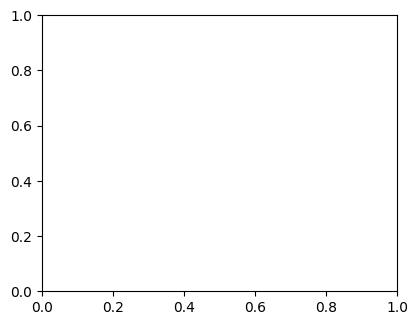

In [11]:
plot_embeddings_grid(emb_dict=iris_transformed, y = target_names)  